# New Requirements

* arrow
* future
* bw2temporalis

Install as usual:

    conda install -y -q -c cmutel arrow future bw2temporalis
    
# Technosphere matrix as a graph

We built the technospehre matrix as a series of linear equations, but we can also think of the matrix as an [adjecency matrix](https://en.wikipedia.org/wiki/Adjacency_matrix). Our supply chain graph is [edge-weighted](https://en.wikipedia.org/wiki/Glossary_of_graph_theory_terms#weighted_graph) and [directed](https://en.wikipedia.org/wiki/Directed_graph).

* It is edge-weighted because the edges (exchanges) have numeric values indicating "how much stuff" flows through that edge.
* It is directed because each edge represents a flow in a certain direction - there is a consumer and a producer. Note that it is possible to have edges in both directions.

There is no "starting point" in such a graph, but we would start with the node which represents the functional unit when traversing the graph.

Why would we want to traverse our graph? Graph traversal gives us more information about where impacts occur, but it also allows us to switch form a strictly linear model to something more complicated.

Let's start by doing a simple graph traversal:

# The temporalis library

In [1]:
import brightway2 as bw
import bw2temporalis as t

In [2]:
bw.projects.set_current("bw2_seminar_2017")

In [13]:
t.dynamic_methods

DynamicMethods dictionary with 5 object(s):
	GTP
	GTP OP base
	GTP OP high
	GTP OP low
	Radiative Forcing

In [14]:
t.dynamic_methods['GTP']

{'from_function': 'create_temperature_methods', 'library': 'cofire'}

In [32]:
t.DynamicIAMethod('GTP').load()

{('biosphere3',
  '0795345f-c7ae-410c-ad25-1845784c75f5'): "def ghg_function(datetime):\n        from bw2temporalis.cofire.constants import ch4_gtp_td_ar5\n        from datetime import timedelta\n        import collections\n        return_tuple = collections.namedtuple('return_tuple', ['dt', 'amount'])\n        return [return_tuple(datetime + timedelta(days=365.24 * x), y) for x, y in ch4_gtp_td_ar5]",
 ('biosphere3',
  '16eeda8a-1ea2-408e-ab37-2648495058dd'): "def ghg_function(datetime):\n        from bw2temporalis.cofire.constants import co2_gtp_td_ar5\n        from datetime import timedelta\n        import collections\n        return_tuple = collections.namedtuple('return_tuple', ['dt', 'amount'])\n        return [return_tuple(datetime + timedelta(days=365.24 * x), y) for x, y in co2_gtp_td_ar5]",
 ('biosphere3',
  '258263a0-6be3-4439-bd84-efee0498b849'): "def ghg_function(datetime):\n        from bw2temporalis.cofire.constants import ch4_gtp_td_ar5\n        from datetime import tim

In [11]:
t.create_cofire_methods()

In [5]:
sorted([x for x in bw.methods if ('GTP' in str(x) or 'Radiative' in str(x))])

[('GTP', 'worst case'),
 ('GTP OP base', 'worst case'),
 ('GTP OP high', 'worst case'),
 ('GTP OP low', 'worst case'),
 ('IPCC 2013', 'climate change', 'GTP 100a'),
 ('IPCC 2013', 'climate change', 'GTP 20a'),
 ('IPCC 2013 no LT', 'climate change', 'GTP 100a'),
 ('IPCC 2013 no LT', 'climate change', 'GTP 20a'),
 ('Radiative Forcing', 'worst case')]

In [16]:
METHANE = ('biosphere3', '0795345f-c7ae-410c-ad25-1845784c75f5')  # Methane, fossil, air, kg
CO2 = ('biosphere3', '349b29d1-3e58-4c66-98b9-9d1a076efd2e')      # CO2, fossil, air, kg
bw.get_activity(METHANE), bw.get_activity(CO2)

('Methane, fossil' (kilogram, None, ('air',)),
 'Carbon dioxide, fossil' (kilogram, None, ('air',)))

In [19]:
data = {
    ('temporalis-example', 'Functional Unit'): {
        'exchanges': [
            {
                'amount': 5,
                'input': ('temporalis-example', 'EOL'),
                'temporal distribution': [
                    (0, 1),
                    (1, 1),
                    (2, 1),
                    (3, 1),
                    (4, 1)
                ],
                'type': 'technosphere'
            },
        ],
        'name': 'Functional Unit',
        'type': 'process'
    },
    ('temporalis-example', 'EOL'): {
        'exchanges': [
            {
                'amount': 0.8,
                'input': ('temporalis-example', 'Waste'),
                'type': 'technosphere'
            },
            {
                'amount': 0.2,
                'input': ('temporalis-example', 'Landfill'),
                'type': 'technosphere'
            },
            {
                'amount': 1,
                'input': ('temporalis-example', 'Use'),
                'type': 'technosphere'
            },
        ],
        'name': 'EOL',
        'type': 'process'
    },
    ('temporalis-example', 'Use'): {
        'exchanges': [
            {
                'amount': 1,
                'input': ('temporalis-example', 'Production'),
                'temporal distribution': [(-0.5, 1)],
                'type': 'technosphere'
            },
        ],
        'name': 'Use',
        'type': 'process'
    },
    ('temporalis-example', 'Production'): {
        'exchanges': [
            {
                'amount': 1,
                'input': ('temporalis-example', 'Transport'),
                'temporal distribution': [(-0.1, 1)],
                'type': 'technosphere'
            },
        ],
        'name': 'Production',
        'type': 'process'
    },
    ('temporalis-example', 'Transport'): {
        'exchanges': [
            {
                'amount': 1,
                'input': ('temporalis-example', 'Sawmill'),
                'type': 'technosphere'
            },
            {
                'amount': 0.1,
                'input': CO2,
                'type': 'biosphere'
            },
        ],
        'name': 'Production',
        'type': 'process'
    },
    ('temporalis-example', 'Sawmill'): {
        'exchanges': [
            {
                'amount': 1.2,
                'input': ('temporalis-example', 'Forest'),
                'temporal distribution': [(-0.5, 1.2)],
                'type': 'technosphere'
            },
            {
                'amount': 0.1,
                'input': CO2,
                'type': 'biosphere'
            },
        ],
        'name': 'Sawmill',
        'type': 'process'
    },
    ('temporalis-example', 'Forest'): {
        'exchanges': [
            {
                'amount': -.2 * 6,
                'input': CO2,
                'temporal distribution': [(x, -.2) for x in (0, 5, 10, 15, 20, 30)],
                'type': 'biosphere'
            },
            {
                'amount': 1.5,
                'input': ('temporalis-example', 'Thinning'),
                'temporal distribution': [
                    (5, .5),
                    (10, .5),
                    (15, .5),
                ],
                'type': 'technosphere'
            },
        ],
        'name': 'Forest',
        'type': 'process'
    },
    ('temporalis-example', 'Thinning'): {
        'exchanges': [
            {
                'amount': 1,
                'input': ('temporalis-example', 'Thinning'),
                'type': 'production'
            },
            {
                'amount': 1,
                'input': ('temporalis-example', 'Avoided impact - thinnings'),
                'type': 'production'
            },
        ],
        'name': 'Thinning',
        'type': 'process'
    },
    ('temporalis-example', 'Landfill'): {
        'exchanges': [
            {
                'amount': 0.1,
                'input': METHANE,
                'temporal distribution': [
                    (20, 0.025),
                    (30, 0.025),
                    (40, 0.025),
                    (50, 0.025)
                ],
                'type': 'biosphere'
            },
        ],
        'name': 'Landfill',
        'type': 'process'
    },
    ('temporalis-example', 'Waste'): {
        'exchanges': [
            {
                'amount': 1,
                'input': ('temporalis-example', 'Waste'),
                'type': 'production'
            },
            {
                'amount': 1,
                'input': ('temporalis-example', 'Avoided impact - waste'),
                'type': 'production'
            },
        ],
        'name': 'Waste',
        'type': 'process'
    },
    ('temporalis-example', 'Avoided impact - waste'): {
        'exchanges': [
            {
                'amount': -0.6,
                'input': CO2,
                'type': 'biosphere'
            },
            {
                'amount': 1,
                'input': ('temporalis-example', 'Avoided impact - waste'),
                'type': 'production'
            },
        ],
        'name': 'Avoided impact - waste',
        'type': 'process'
    },
    ('temporalis-example', 'Avoided impact - thinnings'): {
        'exchanges': [
            {
                'amount': -0.2,
                'input': CO2,
                'type': 'biosphere'
            },
            {
                'amount': 1,
                'input': ('temporalis-example', 'Avoided impact - thinnings'),
                'type': 'production'
            },
        ],
        'name': 'Avoided impact - thinnings',
        'type': 'process'
    }
}

db = bw.Database("temporalis-example")
db.write(data)

Writing activities to SQLite3 database:
0%        100%
[############] | ETA: 00:00:00
Total time elapsed: 00:00:00


Title: Writing activities to SQLite3 database:
  Started: 03/25/2017 20:48:11
  Finished: 03/25/2017 20:48:11
  Total time elapsed: 00:00:00
  CPU %: 119.30
  Memory %: 1.15


In [23]:
lca = bw.LCA({('temporalis-example', 'EOL'): 1}, ('IPCC 2013', 'climate change', 'GWP 100a'))
lca.lci()
lca.lcia()
lca.score

0.19399996739625813

In [24]:
from bw2analyzer import ContributionAnalysis

ContributionAnalysis().annotated_top_processes(lca)

[(-1.4400001144409202, 1.2000000476837158, 'Forest'),
 (0.59400003296136916, 0.20000000298023224, 'Landfill'),
 (0.48000002622604399, -0.80000001192092896, 'Avoided impact - waste'),
 (0.36000001966953299, -1.8000000715255737, 'Avoided impact - thinnings'),
 (0.10000000149011612, 1.0, 'Sawmill'),
 (0.10000000149011612, 1.0, 'Production'),
 (0.0, 0.80000001192092896, 'Waste'),
 (0.0, 1.8000000715255737, 'Thinning'),
 (0.0, 1.0, 'Production'),
 (0.0, 1.0, 'Use'),
 (0.0, 1.0, 'EOL'),
 (0.0, 0.0, 'Functional Unit')]

In [25]:
ContributionAnalysis().annotated_top_emissions(lca)

[(0.59400003296136916, 0.020000000596046452, 'Methane, fossil'),
 (-0.40000006556511103, -0.40000006556511103, 'Carbon dioxide, fossil')]

In [26]:
%matplotlib inline

In [27]:
from matplotlib import pyplot as plt
import numpy as np

In [28]:
dlca = t.DynamicLCA({('temporalis-example', 'EOL'): 1}, ("GTP", "worst case"))
timeline = dlca.calculate()

In [29]:
characterized = timeline.characterize_dynamic("GTP")

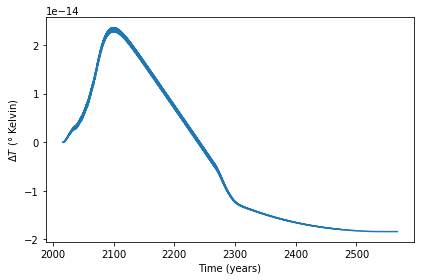

In [30]:
plt.plot(*characterized)
plt.xlabel("Time (years)")
plt.ylabel(r"$\Delta T$ (° Kelvin)")
plt.tight_layout()